In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
sys.path.append("..")

from data import utils
from data import load_raw_data
from models.datasets import SorghumDatasetWithNormals

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
pcd = load_raw_data.load_pcd_plyfile_new_approach("/space/ariyanzarei/sorghum_segmentation/dataset/archive/synthetic/2022-11-06/PointCloud/S11_30.ply", True)

WARNING - 2023-02-09 18:08:58,457 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


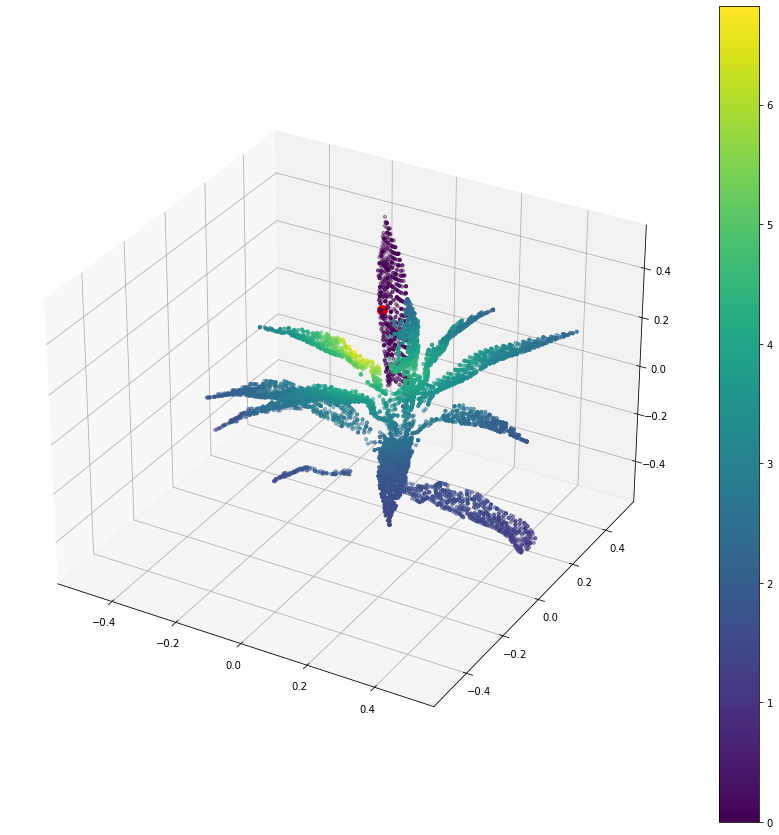

In [37]:
points = torch.from_numpy(pcd['points']).unsqueeze(0)
labels = torch.from_numpy(pcd['labels'].squeeze()).float().view(1,-1, 1)

point_distance = torch.cdist(points, points)
label_distance = (torch.cdist(labels, labels) > 0).int()

distance = (label_distance/(point_distance)).squeeze()

ind = 15

mins, _ = torch.min(points, axis=1)
maxs, _ = torch.max(points, axis=1)
mins = mins.unsqueeze(1)
maxs = maxs.unsqueeze(1)
points = (points - mins) / (maxs - mins) - 0.5

points = points.squeeze()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
m = ax.scatter(points[:,0],points[:,1],points[:,2], c=distance[ind], s=10)
ax.scatter(points[ind,0],points[ind,1],points[ind,2], s=100, c=(1,0,0))
plt.colorbar(m)
plt.show()




WARNING - 2023-02-09 11:07:44,431 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 2023-02-09 11:07:44,436 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[4.08991376e+05 3.66006505e+06 1.04699993e+00]
torch.Size([8000, 20]) torch.Size([142375, 2])
torch.Size([8000, 20]) torch.Size([8000, 20])
tensor(0., dtype=torch.float64) tensor(1.2191, dtype=torch.float64)


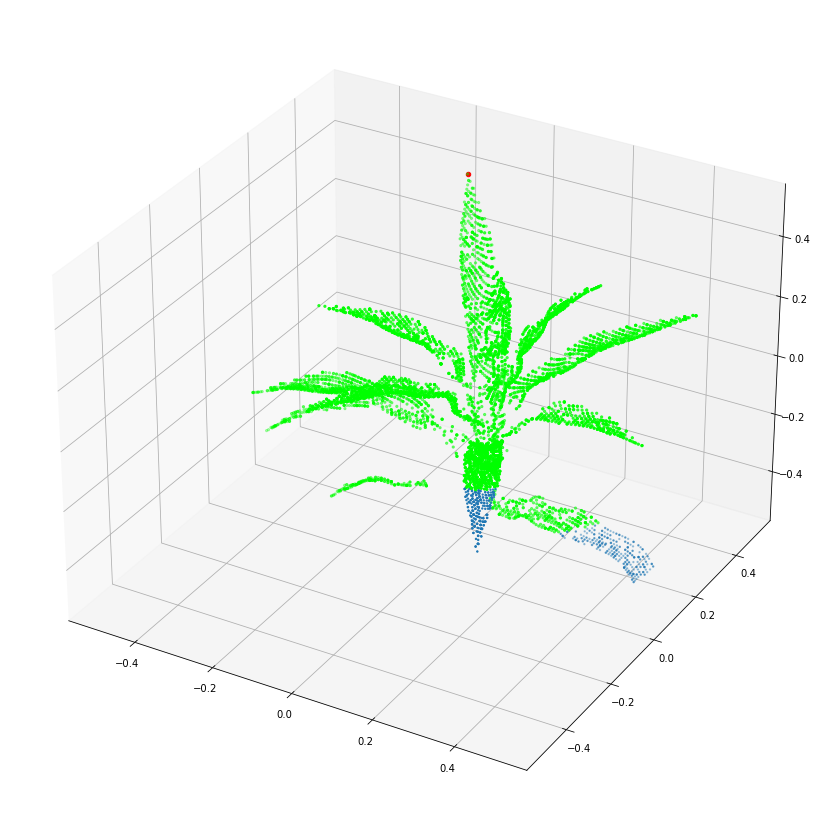

In [38]:

points = pcd['points']
labels = pcd['labels'].squeeze()

maxs = np.max(points, 0)
print(maxs)
ind = np.where(points[:,1] == maxs[1])[0][0]
# ind = np.random.randint(0, points.shape[0])
points = torch.from_numpy(points).type(torch.DoubleTensor).unsqueeze(0)

mins, _ = torch.min(points, axis=1)
maxs, _ = torch.max(points, axis=1)
mins = mins.unsqueeze(1)
maxs = maxs.unsqueeze(1)
points = (points - mins) / (maxs - mins) - 0.5

points = points.squeeze()
distance = torch.cdist(points, points)

knn_values, knn_ind = (distance * -1).topk(k=20, dim=-1)
nonzero_ind = (knn_values<0).nonzero()
print(knn_values.shape, nonzero_ind.shape)
# filtered_ind = knn_ind[]
# print(filtered_ind.shape)
knn_pred_dist = distance.gather(-1, knn_ind)

print(knn_ind.shape, knn_pred_dist.shape)
print(min(distance[ind]),max(distance[ind]))

close_points = np.where(distance[ind]<1)
far_points = np.where(distance[ind]>=1)
distance_colors = distance[ind]

d_colors = utils.distinct_colors(len(set(labels.tolist())))
colors = np.zeros((labels.shape[0], 3))
for i, l in enumerate(list(set(labels.tolist()))):
    colors[labels == l, :] = d_colors[i]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[far_points,0],points[far_points,1],points[far_points,2], s=2)
ax.scatter(points[ind,0],points[ind,1],points[ind,2], s=20, c=(1,0,0))
ax.scatter(points[close_points,0],points[close_points,1],points[close_points,2], s=5, c=(0,1,0))
# ax.scatter(points[:,2],points[:,0],points[:,1], s=5, c=distance_colors)
plt.show()


In [7]:
ds = SorghumDatasetWithNormals("/space/ariyanzarei/sorghum_segmentation/dataset/SPNS/SorghumPartNetFormat/instance_segmentation_train.hdf5", False)

In [9]:
ind = 3

points, labels = ds[ind:ind+2]
print(points.shape)
print(labels.shape)

torch.Size([2, 8000, 3])
torch.Size([2, 8000])


In [19]:
def knn(x, k):
    inner = -2 * torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
    idx = pairwise_distance.topk(k=k, dim=-1)[1]  # (batch_size, num_points, k)
    return idx

In [30]:
k = 5

x = points.transpose(1,2)
batch_size = x.size(0)
num_points = x.size(2)
x = x.view(batch_size, -1, num_points)
idx = knn(x, k)

idx_base = torch.arange(0, batch_size).view(-1, 1, 1) * num_points
idx = idx + idx_base
idx = idx.view(-1)
_, num_dims, _ = x.size()
x = x.transpose(2, 1).contiguous()
knn_coords = x.view(batch_size * num_points, -1)[idx, :]
knn_coords = knn_coords.view(batch_size, num_points, k, num_dims)
print(knn_coords.shape)

torch.Size([2, 8000, 5, 3])


In [2]:
import sys
sys.path.append("..")
from models.nn_models import SorghumPartNetInstance

In [3]:
sorghumpartnet = SorghumPartNetInstance.load_from_checkpoint("/space/ariyanzarei/sorghum_segmentation/results/training_logs/SorghumPartNetInstance/SPNS/EXP_06/checkpoints/epoch=7-step=76799.ckpt")
sorghumpartnet = sorghumpartnet.cuda()

In [4]:
sorghumpartnet.space_reqularizer_module.k_vector

Parameter containing:
tensor([ 0.7080,  1.1259,  0.7274,  0.8934, -0.0987], device='cuda:0',
       requires_grad=True)